### For Assignment 1 you should design your own investigation into the citibike data.¶
#### # Come up with a question about the Citibike data usage. It can be anything that involves Categorical data. # At this point of the class it is easier to run tests of proportions or similar, and work with categorical data. Categorical cn be anhything that can be punt into classes (e.g. day/night, male/female, 2014/2015/2016.... as long as you set up your experiment the proper way!)
#### # Choose the significance threshold
#### # Clearly state they Null and Alternate hypothesis
#### # Wrangle the data so that it is ready for your analysis.

### Acknowledging yw3447's comments on the hypothesis

#### Null hypothesis: 
The ratio of Subscribers using bike on weekends to Subscribers using bike on weekdays is at least as high or higher than the ratio of Customers using bike on weekends to number of Customers riding on weekdays
#### Alternative hypothesis: 
The ratio of Subscribers riding over weekend to riding weekday is less than the ratio of Customers riding on weekends to riding on weekday.

$\alpha$ = 0.05

In [53]:
import pylab as pl
import pandas as pd
import numpy as np
import seaborn
import os
from scipy.optimize import curve_fit, minimize
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [54]:
def getCitiBikeCSV(datestring):
    import os
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [55]:
getCitiBikeCSV('201401')

file in place, you can continue


In [56]:

df = pd.read_csv(os.getenv("PUIDATA") + "/" + '201503'+ '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,669,3/1/2015 0:00,3/1/2015 0:11,164,E 47 St & 2 Ave,40.753231,-73.970325,477,W 41 St & 8 Ave,40.756405,-73.990026,21409,Subscriber,1987.0,1,2015-03-01 00:00:00
1,750,3/1/2015 0:01,3/1/2015 0:14,258,DeKalb Ave & Vanderbilt Ave,40.689407,-73.968855,436,Hancock St & Bedford Ave,40.682166,-73.953990,19397,Subscriber,1968.0,1,2015-03-01 00:01:00
2,663,3/1/2015 0:01,3/1/2015 0:12,497,E 17 St & Broadway,40.737050,-73.990093,477,W 41 St & 8 Ave,40.756405,-73.990026,20998,Customer,NaN,0,2015-03-01 00:01:00
3,480,3/1/2015 0:02,3/1/2015 0:10,470,W 20 St & 8 Ave,40.743453,-74.000040,491,E 24 St & Park Ave S,40.740964,-73.986022,21565,Subscriber,1983.0,1,2015-03-01 00:02:00
4,1258,3/1/2015 0:02,3/1/2015 0:23,345,W 13 St & 6 Ave,40.736494,-73.997044,473,Rivington St & Chrystie St,40.721101,-73.991925,14693,Subscriber,1970.0,1,2015-03-01 00:02:00


In [57]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid','gender',
       'birth year'], axis=1, inplace=True)

In [58]:
df.head()

,usertype,date
0,Subscriber,2015-03-01 00:00:00
1,Subscriber,2015-03-01 00:01:00
2,Customer,2015-03-01 00:01:00
3,Subscriber,2015-03-01 00:02:00
4,Subscriber,2015-03-01 00:02:00


In [59]:
df['usertype'] = df.usertype.replace('Customer', 0)
df['usertype'] = df.usertype.replace('Subscriber', 1)
df.head()

,usertype,date
0,1,2015-03-01 00:00:00
1,1,2015-03-01 00:01:00
2,0,2015-03-01 00:01:00
3,1,2015-03-01 00:02:00
4,1,2015-03-01 00:02:00


Text(0.5,1,'Distribution of Citibike Users by User Type in March 2015')

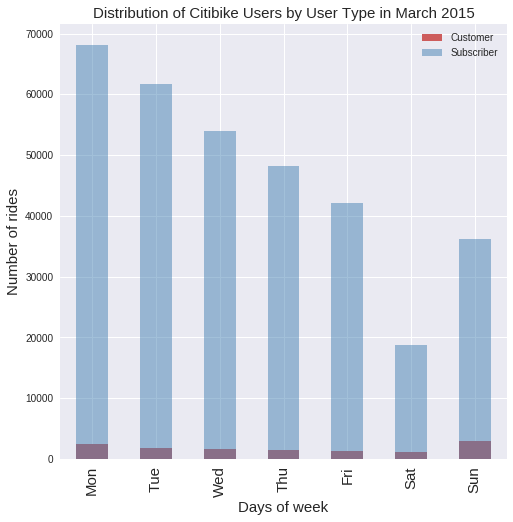

In [60]:
fig = pl.figure(figsize(8,8))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_c = 1
((df['date'][df['usertype'] == 0].groupby([df['date'].dt.weekday]).count()) / norm_c).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='Customer')

norm_s = 1
ax = ((df['date'][df['usertype'] == 1].groupby([df['date'].dt.weekday]).count()) / norm_s).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.5,
                                                                                              label='Subscriber')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=15)
pl.legend()
pl.xlabel('Days of week', fontsize=15)
pl.ylabel('Number of rides', fontsize=15)
pl.title('Distribution of Citibike Users by User Type in March 2015', fontsize=15)

Fig 1. This figure gives us the riding pattern of Customers and Subscribers over the course of 7 days for month March 2015

Text(0.5,1,'Distribution of Citibike riders by User Type in March 2015, with Statistical Errors')

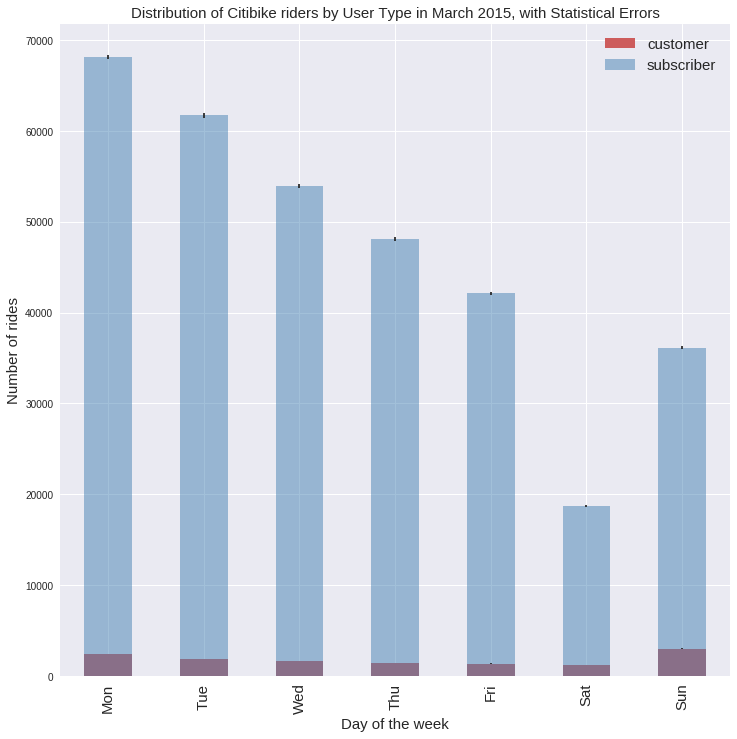

In [61]:
fig=pl.figure(figsize(12,12))

counts_c = df.date[df.usertype == 0].groupby([df.date.dt.weekday]).count()
norm_c = 1
error_c = np.sqrt(counts_c)
ax=((counts_c) / norm_c).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_c) / norm_c, (error_c) / norm_c)], label='customer')


counts_s = df.date[df.usertype==1].groupby([df.date.dt.weekday]).count()
norm_s = 1
error_s=np.sqrt(counts_s)
((counts_s) / norm_s).plot(kind="bar", alpha=0.5, yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                           color='SteelBlue', label='subscriber')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=15)
ax.set_ylabel ("Number of rides", fontsize=15)
ax.set_xlabel ("Day of the week", fontsize=15)
pl.legend(['customer','subscriber'],fontsize=15)
pl.title('Distribution of Citibike riders by User Type in March 2015 with Statistical Errors', fontsize=15)

Fig 2: This figure gives us the riding pattern of Customers and Subscribers over the course of 7 days for month March 2015 with statistical errors

Text(0.5,1,'Normalised Distribution of Citibike Users by User Type in March, 2015')

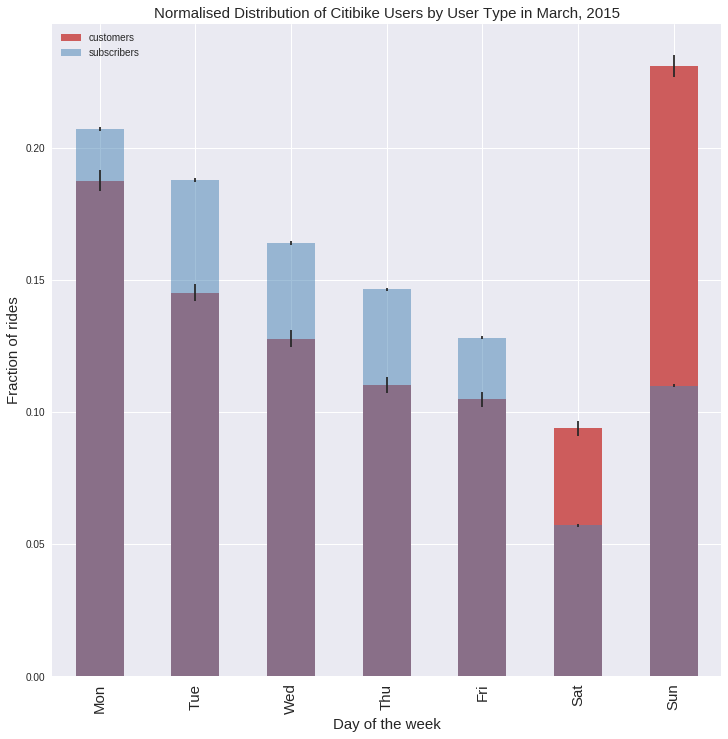

In [63]:
fig = pl.figure(figsize=(12,12))

norm_c = counts_c.sum()
error_c = np.sqrt(counts_c)
((counts_c) / norm_c).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_c) / norm_c, (error_c) / norm_c)], 
                           label='Customers')

norm_s = counts_s.sum()
ax = ((counts_s) / norm_s).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                                color='SteelBlue', label='Subscribers')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=15)
ax.set_ylabel ("Fraction of rides", fontsize=15)
ax.set_xlabel ("Day of the week", fontsize=15)

pl.legend(['customers','subscribers'],fontsize=10, loc='upper left')
pl.title ('Normalised Distribution of Citibike Users by User Type in March, 2015', fontsize=15)

Fig 3: This is the normalised distribution that gives us the riding pattern of Customers and Subscribers over the course of 7 days for month March 2015 with statistical errors

### Seeting up statistical test

Subscriber: week:0.833, weekend:0.167, weekend error:0.002, weekend error:0.001
Customer: week:0.675, weekend:0.325, weekend error:0.007, weekend error:0.005


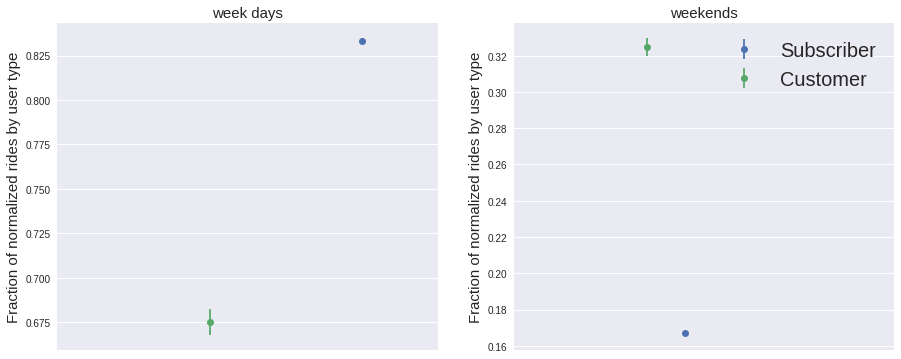

In [64]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])

week_c = sum(counts_c[:-2]) * 1.0 / norm_c  #fraction of customers riding on week days
weekend_c = sum(counts_c[-2:]) * 1.0 / norm_c  #fraction of customers riding on weekends
eweek_c = np.sqrt(sum(error_c[:-2]**2)) / norm_c  #error on fraction number of customers riding on week days
eweekend_c = np.sqrt(sum(error_c[-2:]**2)) / norm_c #error on fraction number of customers riding on weekends

#same nomenclature as above
week_s = sum(counts_s[:-2]) * 1.0 / norm_s
weekend_s = sum(counts_s[-2:]) * 1.0 / norm_s
eweek_s = np.sqrt(sum(error_s[:-2]**2)) / norm_s
eweekend_s = np.sqrt(sum(error_s[-2:]**2)) / norm_s

print("Subscriber: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_s, weekend_s, eweek_s, eweekend_s))
print("Customer: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_c, weekend_c, eweek_c, eweekend_c))

ax1.errorbar([0.4], [week_s], yerr=[eweek_s], fmt='o', label='Subscriber')
ax1.errorbar([0.2], [week_c], yerr=[eweek_c], fmt='o', label='Customer')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [weekend_s], yerr=[eweekend_s], fmt='o', label='Subscriber')
ax2.errorbar([0.2], [weekend_c], yerr=[eweekend_c], fmt='o', label='Customer')
ax1.set_xlim(0, 0.5)
ax1.set_title("week days", fontsize=15)
ax2.set_title("weekends", fontsize=15)
ax2.set_ylabel("Fraction of normalized rides by user type", fontsize=15)
ax1.set_ylabel("Fraction of normalized rides by user type", fontsize=15)

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 20)

Fig 4: This figure displays the fraction of Subscribers ans Customers on weekdays and weekends along with their error components

In [65]:
#checking if the percentage of customers riding on weekends is less than subscribers

P0mP1 = weekend_c - weekend_s
print ("difference between customers and subscribers on weekend: ", P0mP1)
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")


difference between customers and subscribers on weekend:  0.157804571088
We must check the significance before we reject the Null Hypothesis


Since we have 2 groups of Subscribers and Customers and two categorical variables of male and females, we'll be using Chi Sqaure test 

In [66]:
from __future__ import print_function, division
import numpy as np


def evalChisq(values):
    '''Evaluates the chi sq from a contingency value
    Arguments:
    values: 2x2 array or list, the contingengy table
    '''
    if not (len(values.shape) == 2 and values.shape == (2,2)):
        print ("must pass a 2D array")
        return -1
    values = np.array(values)
    E = np.empty_like(values)
    for j in range(len(values[0])):
        for i in range(2):
            
            E[i][j] = ((values[i,:].sum() * values[:,j].sum()) / 
                        (values).sum())
    return ((values - E)**2 / E).sum()

In [67]:
val  = np.array([[week_c*norm_c, weekend_c*norm_c], [week_s*norm_s, weekend_s*norm_s]])
chisq_val = evalChisq(val)
DOF = len(val) - 1
print ('chi sq statistics for "null": '+
       'chisq = {:.3f}, DOF = {:d}'.format(chisq_val, DOF))

chi sq statistics for "null": chisq = 2154.939, DOF = 1


In [68]:
chimin_alpha5pc = 3.84
print ("The Null hypothesis that the ratio of customers riding over weekend to weekday is same or less than the ratio of subscirbers riding on weekends over weekdays,")
if chisq_val > chimin_alpha5pc :
    print ("can be rejected at alpha = 0.05")
else: 
    print ("cannot be rejected (p<0.05)")
print ("with a chi square statistics of %.2f"%chisq_val )

The Null hypothesis that the ratio of customers riding over weekend to weekday is same or less than the ratio of subscirbers riding on weekends over weekdays,
can be rejected at alpha = 0.05
with a chi square statistics of 2154.94


Since the value of chi sqaure statistics is higher than the critical value corresponding to our significance level 0.05 (3.84), we can reject the null hypothesis that the ratio of Subscribers on weekend to weekday is greater than or equal to the ratio of Customers on weekend to weekday

## Checking robustness of data 

In [71]:
datestring = '201401'
getCitiBikeCSV(datestring)

file in place, you can continue


In [73]:
df_04 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df_04['date'] = pd.to_datetime(df_06.starttime)
df_04.head()


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,471,2014-01-01 00:00:06,2014-01-01 00:07:57,2009,Catherine St & Monroe St,40.711174,-73.996826,263,Elizabeth St & Hester St,40.717290,-73.996375,16379,Subscriber,1986,1,2014-01-01 00:00:06
1,1494,2014-01-01 00:00:38,2014-01-01 00:25:32,536,1 Ave & E 30 St,40.741444,-73.975361,259,South St & Whitehall St,40.701221,-74.012342,15611,Subscriber,1963,1,2014-01-01 00:00:38
2,464,2014-01-01 00:03:59,2014-01-01 00:11:43,228,E 48 St & 3 Ave,40.754601,-73.971879,2022,E 59 St & Sutton Pl,40.758491,-73.959206,16613,Subscriber,1991,1,2014-01-01 00:03:59
3,373,2014-01-01 00:05:15,2014-01-01 00:11:28,519,Pershing Square N,40.751884,-73.977702,526,E 33 St & 5 Ave,40.747659,-73.984907,15938,Subscriber,1989,1,2014-01-01 00:05:15
4,660,2014-01-01 00:05:18,2014-01-01 00:16:18,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,436,Hancock St & Bedford Ave,40.682166,-73.953990,19830,Subscriber,1990,1,2014-01-01 00:05:18


In [74]:
df_04.drop(['tripduration','starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'birth year','gender'], axis=1, inplace=True)

In [76]:
df_04.head()

,usertype,date
0,Subscriber,2014-01-01 00:00:06
1,Subscriber,2014-01-01 00:00:38
2,Subscriber,2014-01-01 00:03:59
3,Subscriber,2014-01-01 00:05:15
4,Subscriber,2014-01-01 00:05:18


In [77]:
df_04.usertype = df_04.usertype.replace('Customer', 0)
df_04.usertype = df_04.usertype.replace('Subscriber', 1)
df_04.head()

,usertype,date
0,1,2014-01-01 00:00:06
1,1,2014-01-01 00:00:38
2,1,2014-01-01 00:03:59
3,1,2014-01-01 00:05:15
4,1,2014-01-01 00:05:18


Text(0.5,1,'Normalised Distribution of Citibike Users by User Type in June, 2015')

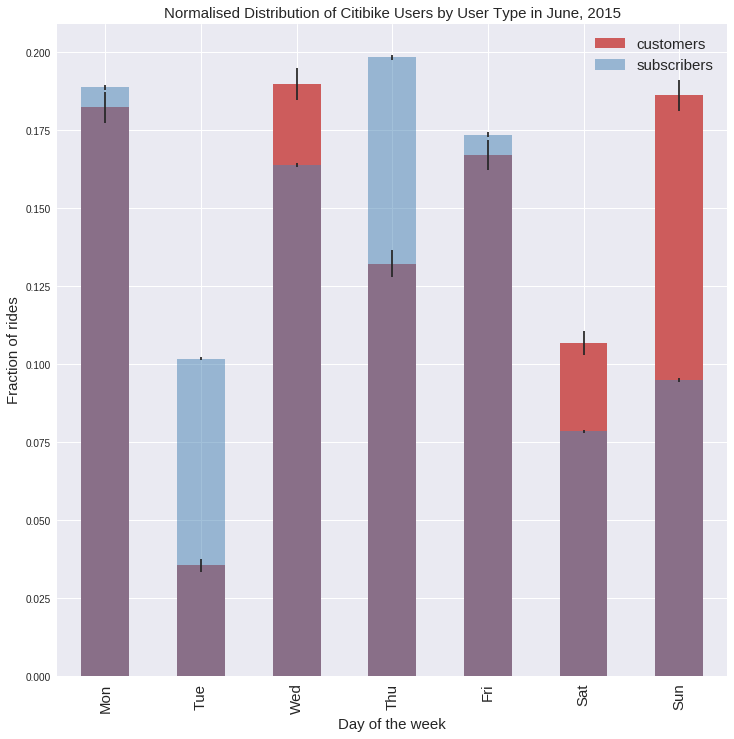

In [80]:
#difficult to compare absolute numbers, normalise the distribution of subscibers and customers 

fig2=pl.figure(figsize(12,12))

counts_c4 = df_04.date[df_04.usertype == 0].groupby([df_04.date.dt.weekday]).count()
norm_c4 = counts_c4.sum()
error_c4= np.sqrt(counts_c4)
((counts_c4) / norm_c4).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_c4) / norm_c4, (error_c4) / norm_c4)], 
                           label='Customers')
counts_s4 = df_04.date[df_04.usertype==1].groupby([df_04.date.dt.weekday]).count()
norm_s4 = counts_s4.sum()
error_s4 = np.sqrt(counts_s4)
ax = ((counts_s4) / norm_s4).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_s4) / norm_s4, (error_s4) / norm_s4)], 
                                color='SteelBlue', label='Subscribers')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=15)
ax.set_ylabel ("Fraction of rides", fontsize=15)
ax.set_xlabel ("Day of the week", fontsize=15)

pl.legend(['customers','subscribers'],fontsize=15, loc='best')
pl.title('Normalised Distribution of Citibike Users by User Type in June, 2015', fontsize=15)

Fig 5: This is the normalised distribution that gives us the riding pattern of Customers and Subscribers over the course of 7 days for month January 2014 with statistical errors

Subscriber: week:0.827, weekend:0.173, weekend error:0.002, weekend error:0.001
Customer: week:0.707, weekend:0.293, weekend error:0.010, weekend error:0.006


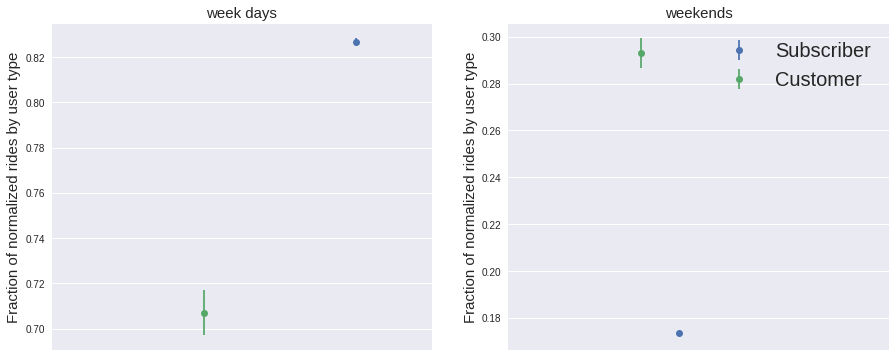

In [81]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])

week_c4 = sum(counts_c4[:-2]) * 1.0 / norm_c4  #fraction of customers riding on week days
weekend_c4 = sum(counts_c4[-2:]) * 1.0 / norm_c4  #fraction of customers riding on weekends
eweek_c4 = np.sqrt(sum(error_c4[:-2]**2)) / norm_c4  #error on fraction number of customers riding on week days
eweekend_c4 = np.sqrt(sum(error_c4[-2:]**2)) / norm_c4 #error on fraction number of customers riding on weekends

#same nomenclature as above
week_s4 = sum(counts_s4[:-2]) * 1.0 / norm_s4
weekend_s4 = sum(counts_s4[-2:]) * 1.0 / norm_s4
eweek_s4 = np.sqrt(sum(error_s4[:-2]**2)) / norm_s4
eweekend_s4 = np.sqrt(sum(error_s4[-2:]**2)) / norm_s4

print("Subscriber: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_s4, weekend_s4, eweek_s4, eweekend_s4))
print("Customer: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_c4, weekend_c4, eweek_c4, eweekend_c4))

ax1.errorbar([0.4], [week_s4], yerr=[eweek_s4], fmt='o', label='Subscriber')
ax1.errorbar([0.2], [week_c4], yerr=[eweek_c4], fmt='o', label='Customer')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [weekend_s4], yerr=[eweekend_s4], fmt='o', label='Subscriber')
ax2.errorbar([0.2], [weekend_c4], yerr=[eweekend_c4], fmt='o', label='Customer')
ax1.set_xlim(0, 0.5)
ax1.set_title("week days", fontsize=15)
ax2.set_title("weekends", fontsize=15)
ax2.set_ylabel("Fraction of normalized rides by user type", fontsize=15)
ax1.set_ylabel("Fraction of normalized rides by user type", fontsize=15) 

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 20)

Fig 6: This figure displays the fraction of Subscribers ans Customers on weekdays and weekends along with their error components

In [82]:
val4  = np.array([[week_c4*norm_c4, weekend_c4*norm_c4], [week_s4*norm_s4, weekend_s4*norm_s4]])
chisq_val4 = evalChisq(val4)
DOF = len(val4) - 1
print ('chi sq statistics for "null": '+
       'chisq = {:.3f}, DOF = {:d}'.format(chisq_val4, DOF))

chi sq statistics for "null": chisq = 696.261, DOF = 1


In [83]:
chimin_alpha5pc = 3.84
print ("The Null hypothesis that the ratio of customers riding over weekend to weekday is same or less than the ratio of subscirbers riding on weekends over weekdays,")
if chisq_val4 > chimin_alpha5pc :
    print ("can be rejected at alpha = 0.05")
else: 
    print ("cannot be rejected (p<0.05)")
print ("with a chi square statistics of %.2f"%chisq_val4 )

The Null hypothesis that the ratio of customers riding over weekend to weekday is same or less than the ratio of subscirbers riding on weekends over weekdays,
can be rejected at alpha = 0.05
with a chi square statistics of 696.26


Since the value of chi sqaure statistics is higher than the critical value corresponding to our significance level 0.05 (3.84), we can reject the null hypothesis that the ratio of Subscribers on weekend to weekday is greater than or equal to the ratio of Customers on weekend to weekday